# Short Time $\Phi_n$ Whitening

In [29]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from dptcomp.dpfunc import s_n, c_n
from dpt.gpu_transform import STPT_gpu, ISTPT_gpu

# Chirp Extraction 

The algorithm is defined by the following method, we have an ASD, a localizable chirp-signal of order $n$, and a specified $n$-frequency range we want to study. We assume the chirp exists within a signal and is well-localized in the $n$-frequency domain with some variance $\sigma_f$ and somewhat localizable in the central-time domain with more variance $\sigma_t$ if its a long-lasting signal.

## Obtaining Amplitude Spectral Density (ASD) of Noise

We must first take some noise process and study how we expect it to transform under a specific short-time-$\Phi_n$ transform waveform analysis. It is dependent on the chirp-frequencies, sampling frequencies, window-size, and (mostly) the chirp-order $n$.

### Defining the region for STPT and ISTPT

In [49]:
# Parameters for the system
fs                 = 1024  # Sampling Frequency
total_time         = 32    # Seconds
N                  = int(fs * total_time)
times              = np.arange(0, total_time, 1 / fs)

n = 3
n_frequency = np.arange(0, 32, 1/32)
window_duration = 2 # Seconds
window_size     = int(window_duration * fs) 

stpt  = STPT_gpu(n, fs, n_frequency, window_size) 
istpt = ISTPT_gpu(n, fs, times, n_frequency, window_size)

Constructing S Matrix (Chirp Order 3.0000): 100%|██████████| 2048/2048 [00:34<00:00, 60.01it/s] 


### Building White Noise Signal or Stationary Noise Signal

In [50]:
sigma         = 1
whiteNoise    = np.random.normal(loc=0.0, scale=np.sqrt(sigma), size=N) # Where you would put the noise process, but you can always get white noise so why anything else.
whiteNoiseTF  = stpt.transform(whiteNoise)[0].get()
asdWhiteNoise = np.median(np.abs(whiteNoiseTF), axis=1)

Text(0.5, 0, '5/8-Frequency (Hz)')

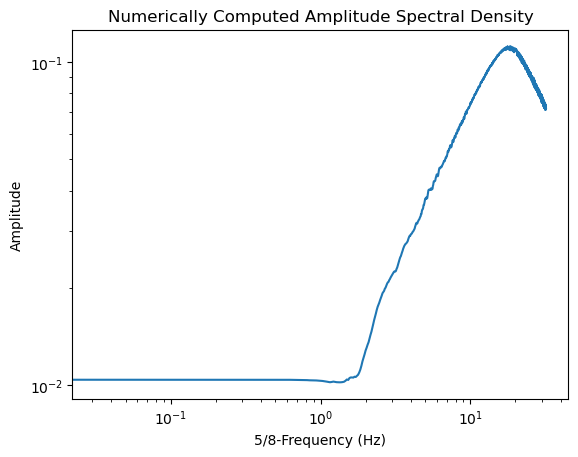

In [51]:
plt.title("Numerically Computed Amplitude Spectral Density")
plt.loglog(n_frequency, asdWhiteNoise)
plt.ylabel("Amplitude")
plt.xlabel("5/8-Frequency (Hz)")

### Let's divide by the ASD and plot the histogram of the normalized power content of the noise.

it's good to note that the white noise should transform onto a flat power spectrum, but the $\Phi_n$ transform is unitary over the entire real line where the noise would be infinitely fine. Thus, expecting a flat power specturm of this approximate noise is incorrect. As the transformation is unitary though we can still do a noise whitening process and analogous results to the Fourier transform.

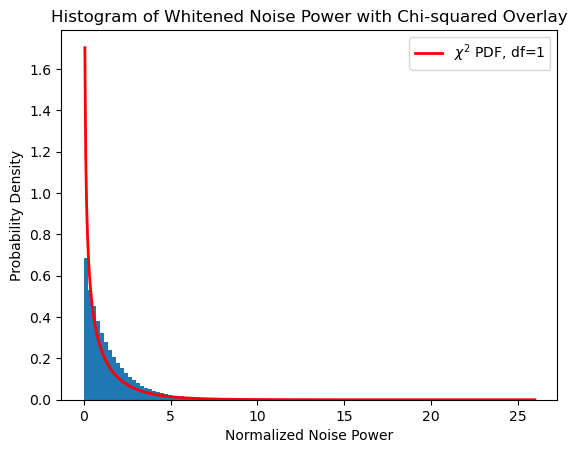

In [52]:
from scipy.stats import chi2

normalizedPower = np.abs(whiteNoiseTF / asdWhiteNoise[None, :].T) ** 2
# Chi-squared PDF with n degrees of freedom
n = 1  # degrees of freedom
x = np.linspace(0, 26, 500)
plt.plot(x, chi2.pdf(x, df=n), 'r-', lw=2, label=fr'$\chi^2$ PDF, df={n}')

plt.title("Histogram of Whitened Noise Power with Chi-squared Overlay")
plt.xlabel("Normalized Noise Power")
plt.ylabel("Probability Density")

plt.hist(normalizedPower.ravel(), bins=100, density=True)
plt.legend()
plt.show()

All the windowed noise signals are not entirely independent of each other, thus this does not really follow a $\chi^2$ distribution. We can try this again if we get some normalized template in the future.

## Step 0: Making a Noisy Signal

In [68]:
# Chirp Parameters: Down Chirp Example
central_time       = 8
waveform_n_freq    = 2
amplitude          = .4
sigmaWindow        = 2
n = 3
mask = times >= central_time
chirpSignal = (
    amplitude
    * s_n(n, waveform_n_freq * (times - central_time))
) * mask * np.exp(- 1/2 * (abs(times - central_time) /  sigmaWindow) ** (2 * n))

# Chirp Parameters: Up Chirp Example
central_time       = 4
waveform_n_freq    = 3
amplitude          = .20
sigmaSig           = 4

mask = times < central_time
chirpSignal = (amplitude * s_n(n, waveform_n_freq * (times - central_time)) * np.exp(- ( abs( (times - central_time) / (sigmaSig)) ) ** (2 * n) / (2 * n))) * mask

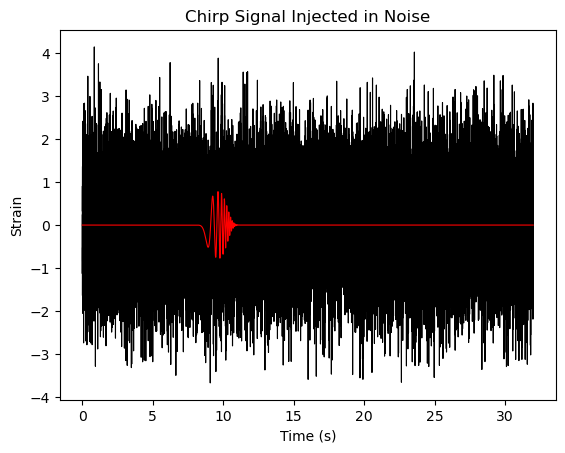

In [69]:
noisySig = chirpSignal + np.random.normal(loc=0.0, scale=np.sqrt(sigma), size=N)
plt.title("Chirp Signal Injected in Noise")
plt.plot(times, noisySig, color="black", lw=.8, label="Noisy Signal")
plt.plot(times, chirpSignal, color="red", lw=.8, label="Injected Chirp")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.savefig("ChirpletInNoise.png")

## Step 1: Transform the Noisy Signal

In [70]:
timeFreqSignal = stpt.transform(noisySig)[0].get()

## Step 2: Look at the Noisy Signal in the Time Frequency Domain (Do You see a signal? I don't)

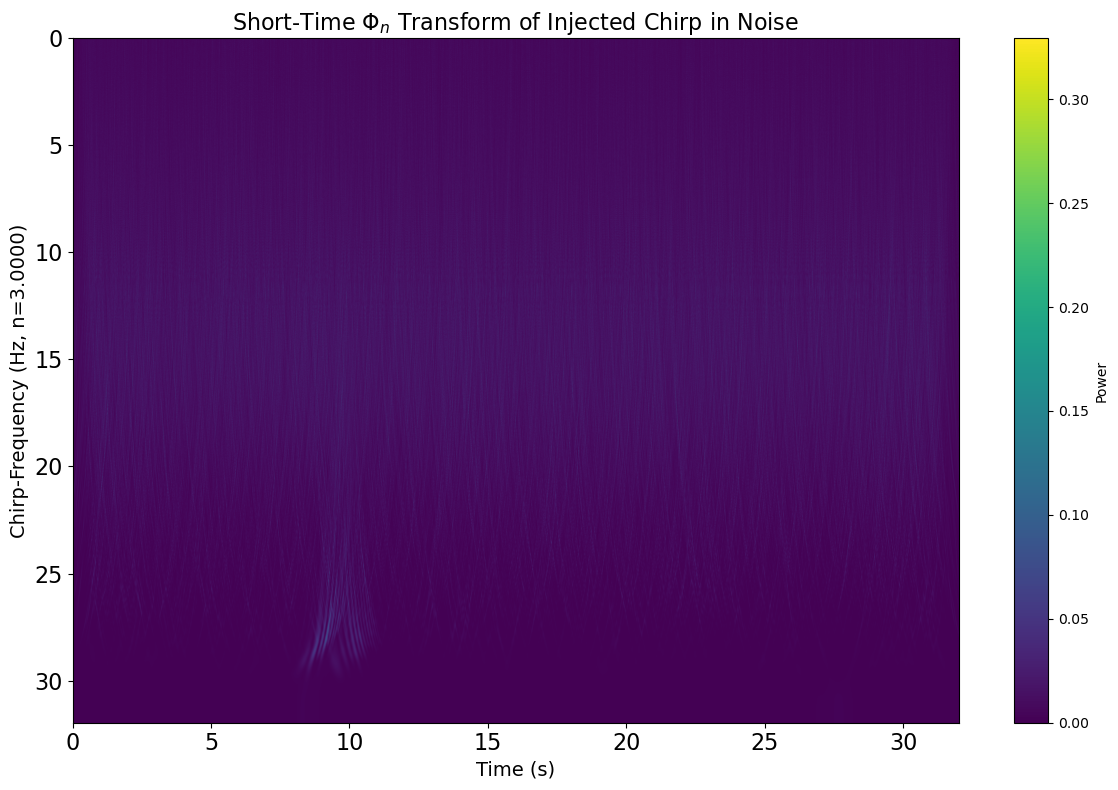

In [71]:
# Plot
plt.figure(figsize=(12, 8))
plt.imshow(
    np.abs(timeFreqSignal) ** 2,
    aspect='auto',
    origin='lower',
    cmap='viridis',
    extent=[times[0], times[-1], n_frequency[-1], n_frequency[0]]
)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel(f"Chirp-Frequency (Hz, n={n:.4f})", fontsize=14)
plt.title(r"Short-Time $\Phi_n$ Transform of Injected Chirp in Noise", fontsize=16)
plt.colorbar(label='Power')
plt.tight_layout()
plt.show()

## Step 3: Whiten using numerical ASD

In [72]:
whitenedTFSignal = timeFreqSignal / asdWhiteNoise[:, np.newaxis]

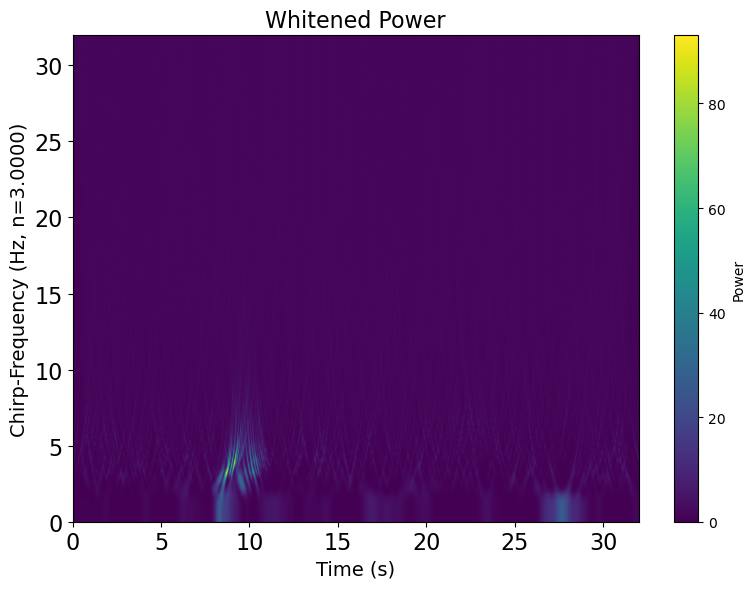

In [80]:
# Define center of the circle
circle_center = (central_time, waveform_n_freq)
circle_radius = 0.2  # Adjust based on your axis scales

# Plot
plt.figure(figsize=(8, 6))
plt.imshow(
    np.abs(whitenedTFSignal) ** 2,
    aspect='auto',
    origin='lower',
    cmap='viridis',
    extent=[times[0], times[-1], n_frequency[0], n_frequency[-1]]
)


plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel(f"Chirp-Frequency (Hz, n={n:.4f})", fontsize=14)
plt.title(r"Whitened Power", fontsize=16)
plt.colorbar(label='Power')
plt.tight_layout()
plt.savefig("WhitenedAmplitudeSpectra")
plt.show()

### Step 4: Filter Whitened Signal

In [74]:
# Compute power matrix
powerMatrix = np.abs(whitenedTFSignal) ** 2

# Find index of maximum power
max_idx_flat = np.argmax(powerMatrix)
max_idx_2d = np.unravel_index(max_idx_flat, powerMatrix.shape)

# Convert to NumPy if needed
i_max, j_max = int(max_idx_2d[0]), int(max_idx_2d[1])
maxFreq = n_frequency[i_max]
maxTime = times[j_max]

print(f"Max at freq={maxFreq:.2f} Hz, time={maxTime:.4f} s")

# Build time-frequency mesh
T, F = np.meshgrid(times, n_frequency)

# Define filter
sigmaF = 2
sigmaT = 4

filter = np.exp(- abs( (F - maxFreq) / sigmaF) ** (2 * n) / (2 * n)) * np.exp(- abs( (T - maxTime) / sigmaT) ** (2 * n) / (2 * n))

Max at freq=3.97 Hz, time=9.1543 s


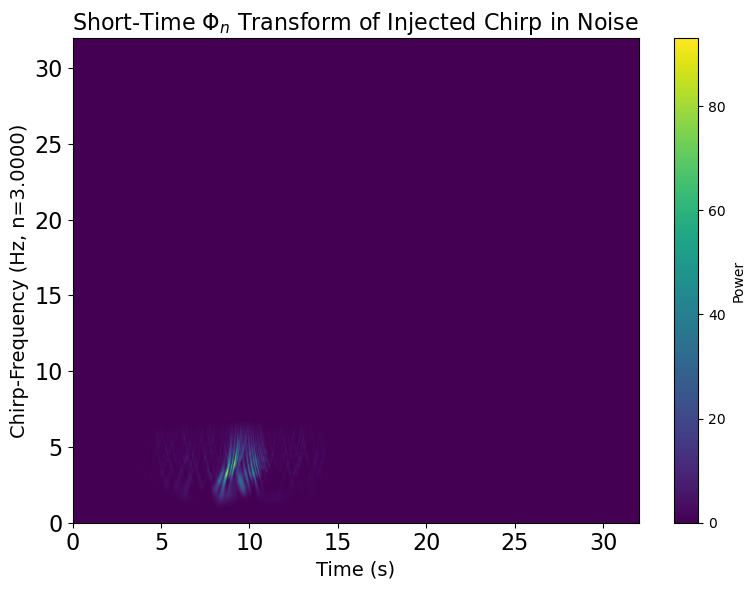

In [75]:
plt.figure(figsize=(8, 6))
plt.imshow(
    np.abs(whitenedTFSignal) ** 2 * filter ** 2,
    aspect='auto',
    origin='lower',
    cmap='viridis',
    extent=[times[0], times[-1], n_frequency[0], n_frequency[-1]]
)


plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel(f"Chirp-Frequency (Hz, n={n:.4f})", fontsize=14)
plt.title(r"Short-Time $\Phi_n$ Transform of Injected Chirp in Noise", fontsize=16)
plt.colorbar(label='Power')
plt.tight_layout()
plt.show()

In [76]:
filteredTFDomain = whitenedTFSignal * filter * asdWhiteNoise[:, np.newaxis]

In [77]:
filteredSignal = istpt.transform(filteredTFDomain).get()

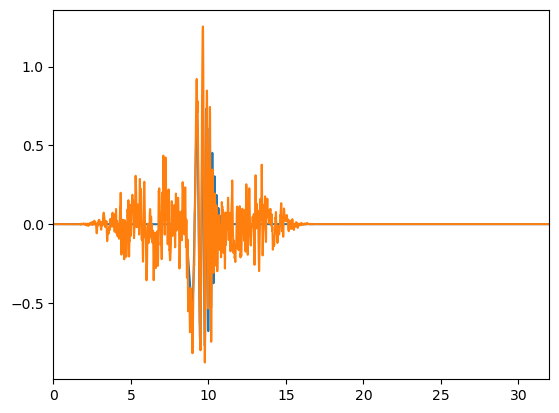

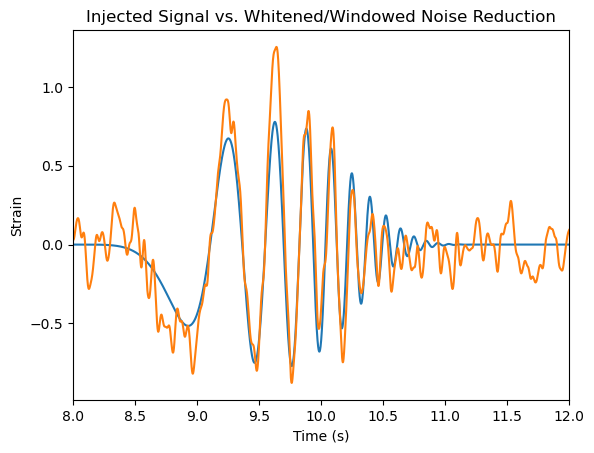

In [82]:
# rms = np.sqrt(np.mean(np.real(filteredSignal) ** 2))
k = 1
plt.plot(times, chirpSignal)
plt.plot(times, np.convolve(np.real(filteredSignal), v=np.ones(k)/k, mode="same"))
plt.xlim(0, 32)
plt.show()

plt.title("Injected Signal vs. Whitened/Windowed Noise Reduction")
plt.plot(times, chirpSignal, label="Original Injected Signal")
plt.plot(times, np.convolve(np.real(filteredSignal), v=np.ones(k)/k, mode="same"), label="Noise Reduced Signal")
plt.xlim(8, 12)
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.savefig("WhitenedRecreation")
plt.show()